In [1]:
%reset
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.ticker as mticker
import warnings; warnings.filterwarnings('ignore')
import cmocean
from xgcm import Grid

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


## Reading in data:

In [3]:
#1/4 degree resolution, surface diagnostics are for uppermost 5 meters.
%cd /glade/p/univ/unyu0004/gmarques/NeverWorld2/baselines/nw2_0.25deg_N15_baseline_hmix5/
fs = xr.open_dataset('static.nc', decode_times=False)
os = xr.open_mfdataset(['sub01/ocean.stats.nc','sub02/ocean.stats.nc'], decode_times=False)
av = xr.open_dataset('averages_00031502.nc', decode_times=False)


# #1/8 degree resolution, surface diagnostics are for uppermost 5 meters.
# %cd /glade/p/univ/unyu0004/gmarques/NeverWorld2/baselines/nw2_0.125deg_N15_baseline_hmix5/
# fs = xr.open_dataset('static.nc', decode_times=False)
# os = xr.open_mfdataset(['sub01/ocean.stats.nc','sub02/ocean.stats.nc'], decode_times=False)
# av = xr.open_dataset('averages_00004502.nc', decode_times=False)

# # #1/16 degree resolution, surface diagnostics are for uppermost 5 meters.
# %cd /glade/p/univ/unyu0004/gmarques/NeverWorld2/baselines/nw2_0.0625deg_N15_baseline_hmix5/
# fs = xr.open_dataset('static.nc', decode_times=False)
# os = xr.open_mfdataset(['sub01/ocean.stats.nc','sub02/ocean.stats.nc','sub03/ocean.stats.nc','sub04/ocean.stats.nc',
#                          'sub05/ocean.stats.nc'], decode_times=False)
# av = xr.open_dataset('averages_00004502.nc', decode_times=False)

# #1/32 degree resolution, surface diagnostics are for uppermost 5 meters.
# %cd /glade/p/univ/unyu0004/gmarques/NeverWorld2/baselines/nw2_0.03125deg_N15_baseline_hmix5
# fs = xr.open_dataset('static.nc', decode_times=False)
# os = xr.open_mfdataset(['sub01/ocean.stats.nc','sub02/ocean.stats.nc','sub03/ocean.stats.nc','sub04/ocean.stats.nc',
#                         'sub05/ocean.stats.nc','sub06/ocean.stats.nc','sub07/ocean.stats.nc','sub08/ocean.stats.nc',
#                         'sub09/ocean.stats.nc','sub10/ocean.stats.nc','sub11/ocean.stats.nc','sub12/ocean.stats.nc',
#                         'sub13/ocean.stats.nc','sub14/ocean.stats.nc','sub15/ocean.stats.nc','sub16/ocean.stats.nc',
#                         'sub17/ocean.stats.nc','sub18/ocean.stats.nc','sub19/ocean.stats.nc','sub20/ocean.stats.nc'], decode_times=False)

# av = xr.open_dataset('averages_00002702.nc', decode_times=False)
%cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/


/glade/campaign/univ/unyu0004/NeverWorld2/nw2_0.25deg_N15_baseline_hmix5
/glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis


In [4]:
grid= Grid(av, coords={'X': {'center': 'xh', 'outer': 'xq'}, #This tells the grid where xh, xq, yh, and yq are defined.
                        'Y': {'center': 'yh', 'outer': 'yq'}});


In [5]:
#Read in various grid variables from the static file and forcing:
lon=fs['geolon']; lat=fs['geolat']
depth = fs['depth_ocean']
depthmat = np.tile(depth,[15,1,1])

area_t=fs['area_t']
xh = fs.xh.values
yh = fs.yh.values

interface_ref=os['H0']#.values; 
interface_ref=interface_ref[-1,:-1]
interface_ref_mat=np.transpose(np.tile(interface_ref,[len(yh),len(xh),1]),[2,0,1])
print(interface_ref_mat.shape)


Layer = (os['Layer']);
drho=av['h'][0,:,0,0]*0.;
drho[0]=Layer[0].values; 
drho[1:]=np.diff((Layer),axis=0)
print(drho); #drho contains the density differences across each interface. 15 entries, includes surface but not bottom.

(15, 560, 240)
<xarray.DataArray 'h' (zl: 15)>
array([1.0226e+03, 2.1000e-01, 3.9000e-01, 5.4000e-01, 5.8000e-01,
       5.8000e-01, 5.7000e-01, 5.3000e-01, 4.8000e-01, 4.2000e-01,
       3.7000e-01, 3.1000e-01, 2.4000e-01, 1.7000e-01, 1.1000e-01],
      dtype=float32)
Coordinates:
    xh       float64 0.125
    yh       float64 -69.88
  * zl       (zl) float64 1.023e+03 1.023e+03 1.023e+03 ... 1.028e+03 1.028e+03
    time     float64 3.15e+04


In [6]:
%%time
h = av['h']; #h[np.isnan(h)]=0.0
correction  = (interface_ref_mat-depthmat); #if >0 this means h_ref is deeper than topography, we need correction!
correction[correction<0]=0.0 #if correction <0 that means depth is larger than h_ref, we don't need correction!

interface = (h)*0.0;
for i in range(0,len(Layer)):
    interface[:,i,:,:]=(h[:,i:,:,:]).sum(axis=1)-depth


interface_ref_HIC = interface_ref_mat- correction
eta_mean=(interface+interface_ref_HIC).mean(axis=0)
eta_eddy=(interface+interface_ref_HIC)- eta_mean;

eta2_mean = (eta_mean**2.)
eta2_eddy = (eta_eddy**2.).mean(axis=0)
print(eta2_mean.shape,eta2_eddy.shape)

APE_mean = 0.5*9.81*(drho)*eta2_mean/(1022.6*depth)
APE_eddy = 0.5*9.81*(drho)*eta2_eddy/(1022.6*depth)
APE_mean  =np.nansum(APE_mean,axis=0)
APE_eddy  =np.nansum(APE_eddy,axis=0)

print('done')

(15, 560, 240) (15, 560, 240)
done
CPU times: user 7.43 s, sys: 4.7 s, total: 12.1 s
Wall time: 14.9 s


In [7]:
%%time
# #COMPUTE velocity components for decomposing KE:
h  = av['h'].mean('time').fillna(0.)
Depth=h.sum('zl')
print('done part 1')
#Outputs are comprised of 100 5-day averages.
u  = av['u'];  u = grid.interp(u,axis='X')
ubar=u.mean('time')

v  = av['v'];  v = grid.interp(v,axis='Y')
vbar=v.mean('time')

uprime=u-ubar
vprime=v-vbar

done part 1
CPU times: user 7.89 s, sys: 4.05 s, total: 11.9 s
Wall time: 20.7 s


In [8]:
%%time
# The mean BT and BC KE values:
ubar_TW=ubar*h/Depth; 
ubar_BT=ubar_TW.sum('zl')
ubar_BC=ubar-ubar_BT;

vbar_TW=vbar*h/Depth
vbar_BT=vbar_TW.sum('zl')
vbar_BC=vbar-vbar_BT;

KE_mean_BT=0.5*(vbar_BT**2+ubar_BT**2) #dim y,x
KE_mean_BC=(0.5*(vbar_BC**2+ubar_BC**2)*h/Depth).sum('zl') #dim y,x

#Eddy BT and BC KE parts:
uprime_BT=(uprime*h/Depth).sum('zl')
uprime_BC=uprime-uprime_BT
vprime_BT=(vprime*h/Depth).sum('zl')
vprime_BC=vprime-vprime_BT
    
KE_eddy_BT=(0.5*(vprime_BT**2+uprime_BT**2)).mean('time')
KE_eddy_BC=((0.5*(vprime_BC**2+uprime_BC**2)*h/Depth).sum('zl')).mean('time')


# #Total kinetic energy:
KE_BT_tot=KE_eddy_BT+KE_mean_BT
KE_BC_tot=KE_eddy_BC+KE_mean_BC
KE_tot=KE_BT_tot+KE_BC_tot


fraction_BT=KE_BT_tot/KE_tot
fraction_BT_mean=KE_mean_BT/KE_tot
fraction_BT_eddy=KE_eddy_BT/KE_tot

fraction_BC=KE_BC_tot/KE_tot#when you divide zero/zero it's a nan
fraction_BC_mean=KE_mean_BC/KE_tot
fraction_BC_eddy=KE_eddy_BC/KE_tot

KE_eddy = KE_eddy_BT+ KE_eddy_BC
KE_mean = KE_mean_BT+ KE_eddy_BC

CPU times: user 2.58 s, sys: 2.53 s, total: 5.11 s
Wall time: 5.1 s


## Save results and repeat for other resolutions before plotting:

In [9]:
yh_025 = yh;
APE_mean_025 = APE_mean
APE_eddy_025 = APE_eddy

KE_mean_BT_025  = KE_mean_BT
KE_mean_BC_025  = KE_mean_BC
KE_eddy_BT_025  = KE_eddy_BT
KE_eddy_BC_025  = KE_eddy_BC

print('done')

done


Text(0.5, 1.0, 'Kinetic Energy')

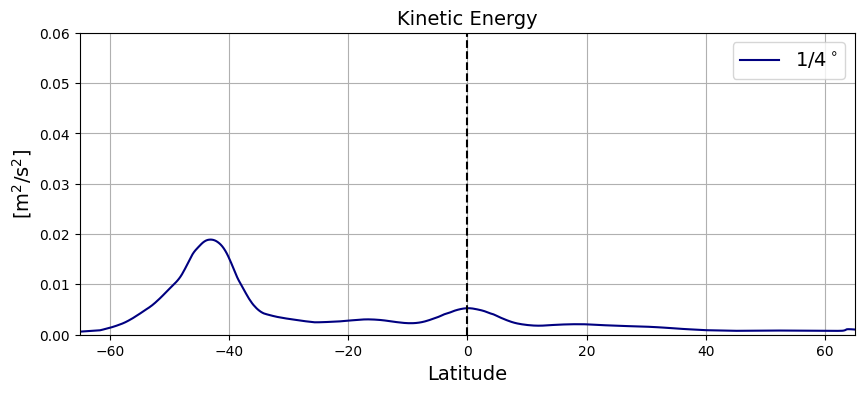

In [10]:
#For the convolution window use N=240 for 1/32 deg.; N=120 for 1/16deg.; N=60 for 1/8deg.; and N=30 for 1/4deg.
window=30

plt.figure(figsize=(10, 4), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(yh_025,np.convolve(np.nanmean(KE_mean_BT_025+KE_mean_BC_025+KE_eddy_BT_025+KE_eddy_BC_025,axis=1), np.ones((window,))/window, mode='same'),'-',color=[0,0,0.5])
#plt.plot(yh_0125,np.convolve(np.nanmean(KE_mean_BT_0125+KE_mean_BC_0125+KE_eddy_BT_0125+KE_eddy_BC_0125,axis=1), np.ones((window,))/window, mode='same'),'-',color=[1,.6,0])
#plt.plot(yh_00625,np.convolve(np.nanmean(KE_mean_BT_00625+KE_mean_BC_00625+KE_eddy_BT_00625+KE_eddy_BC_00625,axis=1), np.ones((window,))/window, mode='same'),'-',color='c')
#plt.plot(yh_003125,np.convolve(np.nanmean(KE_mean_BT_003125+KE_mean_BC_003125+KE_eddy_BT_003125+KE_eddy_BC_003125,axis=1), np.ones((window,))/window, mode='same'),'-',color='m')

plt.grid()

plt.legend(['1/4$^\circ$','1/8$^\circ$','1/16$^\circ$','1/32$^\circ$'],loc='upper right',fontsize=14)
plt.plot([0, 0],[0, 1],'--',color=[0,0,0])
plt.xlim(-65, 65)
plt.ylim(0,.06);
plt.xlabel('Latitude',fontsize=14)
plt.ylabel('[m$^2$/s$^2$]',fontsize=14)
plt.title('Kinetic Energy',fontsize=14)

Text(0.5, 1.0, 'Available Potential Energy')

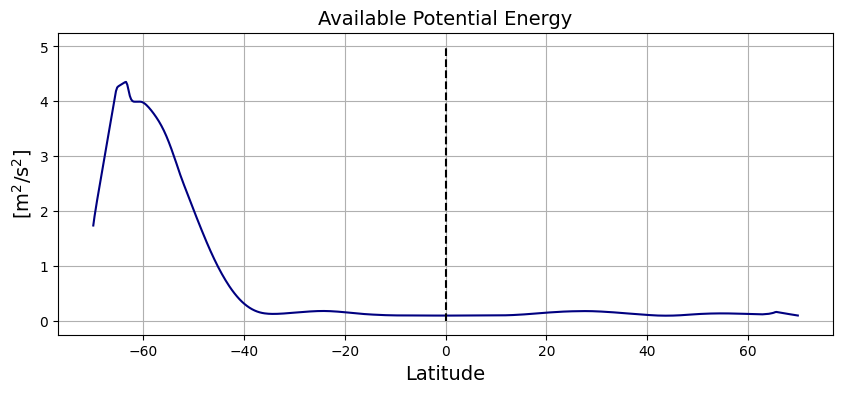

In [11]:
#For the convolution window use N=240 for 1/32 deg.; N=120 for 1/16deg.; N=60 for 1/8deg.; and N=30 for 1/4deg.
window=30


plt.figure(figsize=(10, 4), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(yh_025,np.convolve(np.nanmean(APE_mean_025+APE_eddy_025,axis=1), np.ones((window,))/window, mode='same'),'-',color=[0,0,0.5])
#plt.plot(yh_0125,np.convolve(np.nanmean(APE_mean_0125+APE_eddy_0125,axis=1), np.ones((window,))/window, mode='same'),'-',color=[1,.6,0])
#plt.plot(yh_00625,np.convolve(np.nanmean(APE_mean_00625+APE_eddy_00625,axis=1), np.ones((window,))/window, mode='same'),'-',color='c')
#plt.plot(yh_003125,np.convolve(np.nanmean(APE_mean_003125+APE_eddy_003125,axis=1), np.ones((window,))/window, mode='same'),'-',color='m')

plt.grid()

plt.plot([0, 0],[0, 5],'--',color=[0,0,0])
#plt.xlim(-40, 65)
#plt.yticks([0,0.1,0.2])
#plt.ylim(0,.2);

plt.xlabel('Latitude',fontsize=14)
plt.ylabel('[m$^2$/s$^2$]',fontsize=14)
plt.title('Available Potential Energy',fontsize=14)

Text(0.5, 1.0, 'Eddy APE to Eddy KE Ratio')

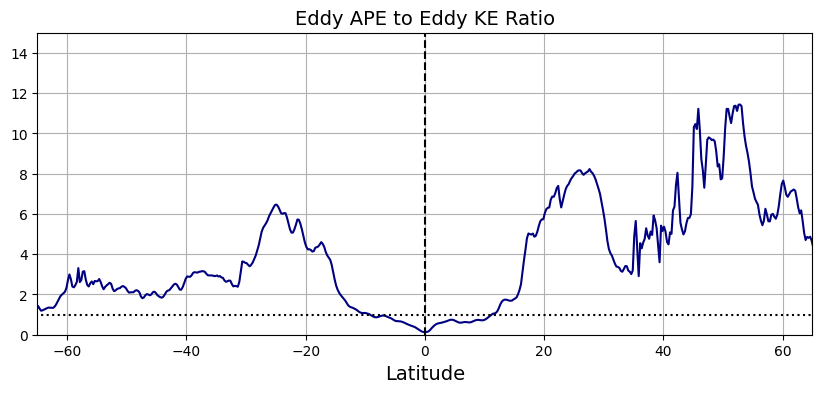

In [12]:
plt.figure(figsize=(10, 4), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(yh_025,np.nanmean(APE_eddy_025,axis=1)/np.nanmean(KE_eddy_BT_025+KE_eddy_BC_025,axis=1),'-',color=[0,0,0.5])
#plt.plot(yh_0125,np.nanmean(APE_eddy_0125,axis=1)/np.nanmean(KE_eddy_BT_0125+KE_eddy_BC_0125,axis=1),'-',color=[1,.6,0])
#plt.plot(yh_00625,np.nanmean(APE_eddy_00625,axis=1)/np.nanmean(KE_eddy_BT_00625+KE_eddy_BC_00625,axis=1),'-',c='c')
#plt.plot(yh_003125,np.nanmean(APE_eddy_003125,axis=1)/np.nanmean(KE_eddy_BT_003125+KE_eddy_BC_003125,axis=1),'-',c='m')



plt.grid()

#plt.legend(['1/4$^\circ$','1/8$^\circ$','1/16$^\circ$','1/32$^\circ$'],fontsize=12)
plt.plot([0, 0],[0, 10000],'--',color=[0,0,0])
plt.plot([-70, 70],[1, 1],':',color=[0,0,0])

plt.xlim(-65,65)

plt.ylim(0,15);
plt.xlabel('Latitude',fontsize=14)
plt.title('Eddy APE to Eddy KE Ratio',fontsize=14)